In [1]:
from typing import Callable, List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch import Tensor
from torch.optim import Optimizer
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.utils import accuracy
from typing_extensions import Literal, TypedDict

In [2]:
dataset = Planetoid("../data/Cora", name="Cora")
num_nodes = dataset.data.num_nodes
# For num. edges see:
# - https://github.com/pyg-team/pytorch_geometric/issues/343
# - https://github.com/pyg-team/pytorch_geometric/issues/852
num_edges = dataset.data.num_edges // 2
train_len = dataset[0].train_mask.sum()
val_len = dataset[0].val_mask.sum()
test_len = dataset[0].test_mask.sum()
other_len = num_nodes - train_len - val_len - test_len
print(f"Dataset: {dataset.name}")
print(f"Num. nodes: {num_nodes} (train={train_len}, val={val_len}, test={test_len}, other={other_len})")
print(f"Num. edges: {num_edges}")
print(f"Num. node features: {dataset.num_node_features}")
print(f"Num. classes: {dataset.num_classes}")
print(f"Dataset len.: {dataset.len()}")

Dataset: Cora
Num. nodes: 2708 (train=140, val=500, test=1000, other=1068)
Num. edges: 5278
Num. node features: 1433
Num. classes: 7
Dataset len.: 1


In [3]:
dataset = Planetoid("../data/Cora", name="Cora")
print(f"Sum of row values without normalization: {dataset[0].x.sum(dim=-1)}")

dataset = Planetoid("../data/Cora", name="Cora", transform=T.NormalizeFeatures())
print(f"Sum of row values with normalization: {dataset[0].x.sum(dim=-1)}")

Sum of row values without normalization: tensor([ 9., 23., 19.,  ..., 18., 14., 13.])
Sum of row values with normalization: tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000])


In [4]:
class GCN(torch.nn.Module):
    def __init__(
        self,
        num_node_features: int,
        num_classes: int,
        hidden_dim: int = 16,
        dropout_rate: float = 0.5,
    ) -> None:
        super().__init__()
        self.dropout1 = torch.nn.Dropout(dropout_rate)
        self.conv1 = GCNConv(num_node_features, hidden_dim)
        self.relu = torch.nn.ReLU(inplace=True)
        self.dropout2 = torch.nn.Dropout(dropout_rate)
        self.conv2 = GCNConv(hidden_dim, num_classes)

    def forward(self, x: Tensor, edge_index: Tensor) -> torch.Tensor:
        x = self.dropout1(x)
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.conv2(x, edge_index)
        return x
print("Graph Convolutional Network (GCN):")
GCN(dataset.num_node_features, dataset.num_classes)

Graph Convolutional Network (GCN):


GCN(
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv1): GCNConv(1433, 16)
  (relu): ReLU(inplace=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv2): GCNConv(16, 7)
)

In [5]:
LossFn = Callable[[Tensor, Tensor], Tensor]
Stage = Literal["train", "val", "test"]


def train_step(
    model: torch.nn.Module, data: Data, optimizer: torch.optim.Optimizer, loss_fn: LossFn
) -> Tuple[float, float]:
    model.train()
    optimizer.zero_grad()
    mask = data.train_mask
    logits = model(data.x, data.edge_index)[mask]
    preds = logits.argmax(dim=1)
    y = data.y[mask]
    loss = loss_fn(logits, y)
    # + L2 regularization to the first layer only
    # for name, params in model.state_dict().items():
    #     if name.startswith("conv1"):
    #         loss += 5e-4 * params.square().sum() / 2.0

    acc = accuracy(preds, y)
    loss.backward()
    optimizer.step()
    return loss.item(), acc


@torch.no_grad()
def eval_step(model: torch.nn.Module, data: Data, loss_fn: LossFn, stage: Stage) -> Tuple[float, float]:
    model.eval()
    mask = getattr(data, f"{stage}_mask")
    logits = model(data.x, data.edge_index)[mask]
    preds = logits.argmax(dim=1)
    y = data.y[mask]
    loss = loss_fn(logits, y)
    # + L2 regularization to the first layer only
    # for name, params in model.state_dict().items():
    #     if name.startswith("conv1"):
    #         loss += 5e-4 * params.square().sum() / 2.0

    acc = accuracy(preds, y)
    return loss.item(), acc

In [6]:
class HistoryDict(TypedDict):
    loss: List[float]
    acc: List[float]
    val_loss: List[float]
    val_acc: List[float]


def train(
    model: torch.nn.Module,
    data: Data,
    optimizer: torch.optim.Optimizer,
    loss_fn: LossFn = torch.nn.CrossEntropyLoss(),
    max_epochs: int = 200,
    early_stopping: int = 10,
    print_interval: int = 20,
    verbose: bool = True,
) -> HistoryDict:
    history = {"loss": [], "val_loss": [], "acc": [], "val_acc": []}
    for epoch in range(max_epochs):
        loss, acc = train_step(model, data, optimizer, loss_fn)
        val_loss, val_acc = eval_step(model, data, loss_fn, "val")
        history["loss"].append(loss)
        history["acc"].append(acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        # The official implementation in TensorFlow is a little different from what is described in the paper...
        if epoch > early_stopping and val_loss > np.mean(history["val_loss"][-(early_stopping + 1) : -1]):
            if verbose:
                print("\nEarly stopping...")

            break

        if verbose and epoch % print_interval == 0:
            print(f"\nEpoch: {epoch}\n----------")
            print(f"Train loss: {loss:.4f} | Train acc: {acc:.4f}")
            print(f"  Val loss: {val_loss:.4f} |   Val acc: {val_acc:.4f}")

    test_loss, test_acc = eval_step(model, data, loss_fn, "test")
    if verbose:
        print(f"\nEpoch: {epoch}\n----------")
        print(f"Train loss: {loss:.4f} | Train acc: {acc:.4f}")
        print(f"  Val loss: {val_loss:.4f} |   Val acc: {val_acc:.4f}")
        print(f" Test loss: {test_loss:.4f} |  Test acc: {test_acc:.4f}")

    return history
def plot_history(history: HistoryDict, title: str, font_size: Optional[int] = 14) -> None:
    plt.suptitle(title, fontsize=font_size)
    ax1 = plt.subplot(121)
    ax1.set_title("Loss")
    ax1.plot(history["loss"], label="train")
    ax1.plot(history["val_loss"], label="val")
    plt.xlabel("Epoch")
    ax1.legend()

    ax2 = plt.subplot(122)
    ax2.set_title("Accuracy")
    ax2.plot(history["acc"], label="train")
    ax2.plot(history["val_acc"], label="val")
    plt.xlabel("Epoch")
    ax2.legend()

In [17]:
SEED = 42
MAX_EPOCHS = 1000
LEARNING_RATE = 0.005
WEIGHT_DECAY = 5e-4
EARLY_STOPPING = 100


torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GCN(dataset.num_node_features, dataset.num_classes).to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer, max_epochs=MAX_EPOCHS, early_stopping=EARLY_STOPPING)


Epoch: 0
----------
Train loss: 1.9452 | Train acc: 0.1643
  Val loss: 1.9444 |   Val acc: 0.1280

Epoch: 20
----------
Train loss: 1.8354 | Train acc: 0.5929
  Val loss: 1.8866 |   Val acc: 0.3660

Epoch: 40
----------
Train loss: 1.6701 | Train acc: 0.7143
  Val loss: 1.8000 |   Val acc: 0.5140

Epoch: 60
----------
Train loss: 1.4585 | Train acc: 0.8857
  Val loss: 1.6783 |   Val acc: 0.7040

Epoch: 80
----------
Train loss: 1.2547 | Train acc: 0.8000
  Val loss: 1.5366 |   Val acc: 0.7360

Epoch: 100
----------
Train loss: 1.0641 | Train acc: 0.8500
  Val loss: 1.4057 |   Val acc: 0.7480

Epoch: 120
----------
Train loss: 0.9015 | Train acc: 0.8857
  Val loss: 1.2879 |   Val acc: 0.7580

Epoch: 140
----------
Train loss: 0.7911 | Train acc: 0.9357
  Val loss: 1.1861 |   Val acc: 0.7740

Epoch: 160
----------
Train loss: 0.6724 | Train acc: 0.9071
  Val loss: 1.1052 |   Val acc: 0.7820

Epoch: 180
----------
Train loss: 0.5705 | Train acc: 0.9357
  Val loss: 1.0524 |   Val acc: 0.7

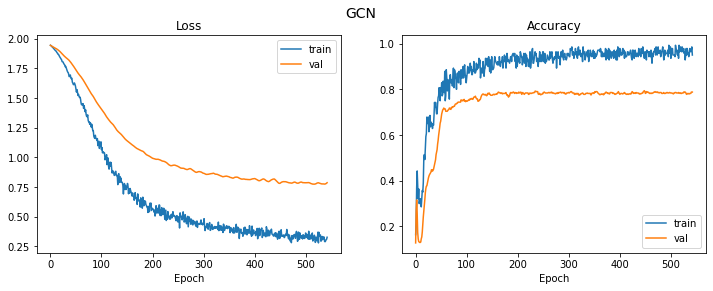

In [18]:
plt.figure(figsize=(12, 4))
plot_history(history, "GCN")